In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pathlib
import warnings

from sklearn.utils import shuffle, parallel_backend
from sklearn.exceptions import ConvergenceWarning
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
)
from joblib import load
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
# load training data from indexes and features dataframe
data_split_path = pathlib.Path(f"../0.split_data/indexes/data_split_indexes.tsv")
data_path = pathlib.Path("../../data/SHSY5Y_preprocessed_sc_norm.parquet")
# dataframe with only the labeled data we want (exclude certain phenotypic classes)
data_df = pq.read_table(data_path).to_pandas()
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)

# subset data_df by indexes in data_split_indexes
training_data = data_df.loc[data_split_indexes["labeled_data_index"]]

In [3]:
# read in toml file and get parameters
import toml

toml_path = pathlib.Path("../1.train_models/multi_class_config.toml")
with open(toml_path, "r") as f:
    config = toml.load(f)
control = config["logistic_regression_params"]["control"]
treatments = config["logistic_regression_params"]["treatments"]

In [4]:
# get oneb_Metadata_Treatment_Dose_Inhibitor_Dose  =='DMSO_0.100_DMSO_0.025' and 'LPS_100.000_DMSO_0.025 and Thapsigargin_10.000_DMSO_0.025'
# set tmp_lst tp select on
tmp_lst = [control] + treatments
training_data = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(tmp_lst)
]

In [5]:
# at random downsample the DMSO treatment to match the number of wells in the LPS treatment
# get the number of wells in the LPS treatment
trt_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == treatments[0]
].shape[0]
# get the number of wells in the DMSO treatment
dmso_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].shape[0]
# downsample the DMSO treatment to match the number of wells in the LPS treatment
dmso_holdout = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].sample(n=trt_wells)
# remove the downsampled DMSO wells from the data
training_data = training_data.drop(dmso_holdout.index)
training_data

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrGasdermin_3_01_256,Nuclei_Texture_SumVariance_CorrMito_3_03_256,Nuclei_Texture_SumVariance_CorrPM_3_03_256,Metadata_Treatment,Metadata_Dose,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,twob_Metadata_Treatment_Dose_Inhibitor_Dose,threeb_Metadata_Treatment_Dose_Inhibitor_Dose,fourb_Metadata_Treatment_Dose_Inhibitor_Dose
27315,SH-SY5Y,B14,4281,6,DMSO,0.025,%,DMSO,0.1,%,...,0.410355,-0.061888,-0.124722,-0.020174,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
31596,SH-SY5Y,C14,4260,6,DMSO,0.025,%,DMSO,0.1,%,...,-0.571918,-0.071949,-0.120070,-0.058321,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
97540,SH-SY5Y,E16,4346,6,DMSO,0.025,%,LPS,10.0,µg_per_ml,...,-0.322372,-0.032871,0.442705,-0.044028,LPS,10.000,LPS_10.000_DMSO_0.025,LPS_DMSO_0.025__10.000,LPS__10.000__DMSO_0.025,LPS__10.000__DMSO__0.025
126524,SH-SY5Y,E17,4128,6,DMSO,0.025,%,LPS,10.0,µg_per_ml,...,-0.651817,0.095457,-0.111786,-0.061318,LPS,10.000,LPS_10.000_DMSO_0.025,LPS_DMSO_0.025__10.000,LPS__10.000__DMSO_0.025,LPS__10.000__DMSO__0.025
211038,SH-SY5Y,E20,4168,6,DMSO,0.025,%,LPS,10.0,µg_per_ml,...,-0.926919,-0.067625,-0.126707,-0.066695,LPS,10.000,LPS_10.000_DMSO_0.025,LPS_DMSO_0.025__10.000,LPS__10.000__DMSO_0.025,LPS__10.000__DMSO__0.025
239179,SH-SY5Y,E21,4168,6,DMSO,0.025,%,LPS,10.0,µg_per_ml,...,-0.773279,-0.066351,-0.100492,-0.049806,LPS,10.000,LPS_10.000_DMSO_0.025,LPS_DMSO_0.025__10.000,LPS__10.000__DMSO_0.025,LPS__10.000__DMSO__0.025
365358,SH-SY5Y,I15,4720,6,DMSO,0.025,%,DMSO,0.1,%,...,1.182799,-0.040164,0.026158,-0.010151,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
370078,SH-SY5Y,J15,4439,6,DMSO,0.025,%,DMSO,0.1,%,...,2.245219,0.030553,0.787386,0.155372,DMSO,0.100,DMSO_0.100_DMSO_0.025,DMSO_DMSO_0.025__0.100,DMSO__0.100__DMSO_0.025,DMSO__0.100__DMSO__0.025
398127,SH-SY5Y,J16,4103,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.110052,-0.043546,0.347336,-0.030643,LPS,100.000,LPS_100.000_DMSO_0.025,LPS_DMSO_0.025__100.000,LPS__100.000__DMSO_0.025,LPS__100.000__DMSO__0.025
425261,SH-SY5Y,J17,4136,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,-0.804121,-0.068221,0.032382,-0.052747,LPS,100.000,LPS_100.000_DMSO_0.025,LPS_DMSO_0.025__100.000,LPS__100.000__DMSO_0.025,LPS__100.000__DMSO__0.025


In [6]:
# define metadata columns
# subset each column that contains metadata
metadata = training_data.filter(regex="Metadata")
# drop all metadata columns
data_x = training_data.drop(metadata.columns, axis=1)
labeled_data = training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
labeled_data

27315      DMSO_0.100_DMSO_0.025
31596      DMSO_0.100_DMSO_0.025
97540      LPS_10.000_DMSO_0.025
126524     LPS_10.000_DMSO_0.025
211038     LPS_10.000_DMSO_0.025
239179     LPS_10.000_DMSO_0.025
365358     DMSO_0.100_DMSO_0.025
370078     DMSO_0.100_DMSO_0.025
398127    LPS_100.000_DMSO_0.025
425261    LPS_100.000_DMSO_0.025
499111    LPS_100.000_DMSO_0.025
524488    LPS_100.000_DMSO_0.025
Name: oneb_Metadata_Treatment_Dose_Inhibitor_Dose, dtype: object

In [7]:
# define the model save name
treatments_str = ""
for i in tmp_lst:
    # if not last in list
    if i != tmp_lst[-1]:
        treatments_str += i + "__"
    else:
        treatments_str += i
treatments_str

'DMSO_0.100_DMSO_0.025__LPS_10.000_DMSO_0.025__LPS_100.000_DMSO_0.025'

In [8]:
# set model path from parameters
model_path = pathlib.Path(f"./models/multi_class/{treatments_str}")

In [9]:
# set path for figures
figure_path = pathlib.Path(f"./figures/multi_class/{treatments_str}")
figure_path.mkdir(parents=True, exist_ok=True)

final CP
../1.train_models/models/multi_class/DMSO_0.100_DMSO_0.025__LPS_10.000_DMSO_0.025__LPS_100.000_DMSO_0.025/final__CP.joblib
../1.train_models/models/multi_class/DMSO_0.100_DMSO_0.025__LPS_1.000_DMSO_0.025__LPS_100.000_DMSO_0.025/final__CP.joblib


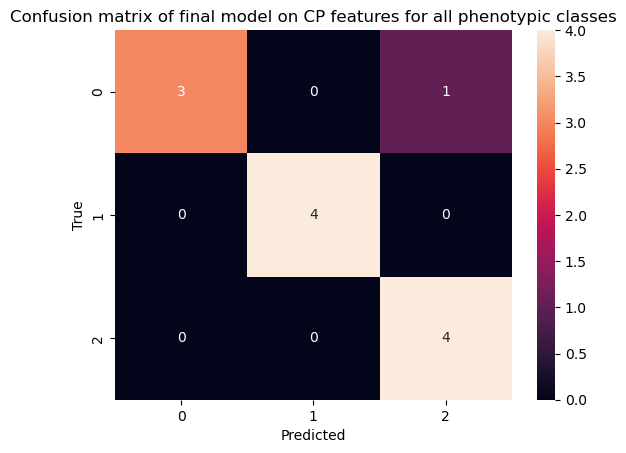

shuffled_baseline CP
../1.train_models/models/multi_class/DMSO_0.100_DMSO_0.025__LPS_10.000_DMSO_0.025__LPS_100.000_DMSO_0.025/shuffled_baseline__CP.joblib
../1.train_models/models/multi_class/DMSO_0.100_DMSO_0.025__LPS_1.000_DMSO_0.025__LPS_100.000_DMSO_0.025/final__CP.joblib


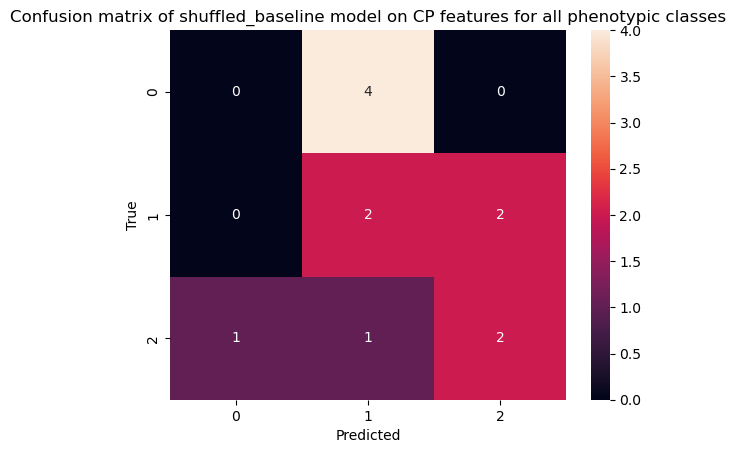

In [10]:
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP"]

# test model on testing data
for model_type, feature_type in itertools.product(model_types, feature_types):
    print(model_type, feature_type)
    # load model
    print(f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib")
    print(
        "../1.train_models/models/multi_class/DMSO_0.100_DMSO_0.025__LPS_1.000_DMSO_0.025__LPS_100.000_DMSO_0.025/final__CP.joblib"
    )
    model = load(f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib")

    # get predictions
    predictions = model.predict(data_x)

    # get probabilities

    probabilities = model.predict_proba(data_x)

    # get accuracy
    accuracy = accuracy_score(labeled_data, predictions)

    # get f1 score
    f1 = f1_score(labeled_data, predictions, average="weighted")

    # plot confusion matrix heatmap
    sns.heatmap(confusion_matrix(labeled_data, predictions), annot=True, fmt="g")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(
        f"Confusion matrix of {model_type} model on {feature_type} features for all phenotypic classes"
    )
    plt.savefig(f"{figure_path}/{model_type}__{feature_type}__confusion_matrix.png")
    plt.show()